In [46]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import NSR_identifier as nsr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from typing import Optional, Union

### Read in some of the large data files in advance. The data in these files will be reused many times

In [47]:
SOIL_PROPERTY = pd.read_excel("../../NEON soil properties/20220928_NRCS-NEONDataset.xlsx", sheet_name="rdata") # read in soil properties from NRCS
ORGANIC_CARBON = pd.read_excel("../../NEON soil properties/20220928_NRCS-NEONDataset.xlsx", sheet_name="Data") # read in soil organic carbon 
NUMERICAL_VELOCITY = pd.read_excel('E:/AI4PF/doc/NEON soil properties/Amato_NEON_velocity results.xlsx', 
                                   sheet_name=['Median Velocity','95th Velocity','99th Velocity'], index_col = 0) # velocity from numerical simulation in log scale.
ARIDITY = pd.read_csv("../../../NEONaridityandcanopy.csv", index_col=0) # NEON aridity files 
SITE_CONDITION_VARS = pd.read_csv("E:/AI4PF/NEON_Field_Site_Metadata_20230309.csv") # NEON site condition variables
SENSOR_DEPTH = pd.read_csv("E:/AI4PF/data/NEON_soil_moisture/swc_depthsV2.csv") # NEON sensor depth dataset

In [48]:
def get_weighted_soil_params(sensor_depth, site_name):
    """get the horizon weighted soil parameters.

    Args:
        site_name (str): site name.
        sensor_depth (float): sensor depth in cm.

    Returns:
        dict: soil parameters.
    """
    sand_weighted = np.nan
    clay_weighted = np.nan
    silt_weighted = np.nan
    porosity_weighted = np.nan
    eff_porosity_weighted = np.nan 
    root_density_weight = np.nan
    
    basic_info = ["siteid", "hzndept",
                  "hzndepb","sandtotal", "silttotal", 
                  "claytotal", "totalporosity",
                  "effectiveporosity", 
                  "lteq2mmincrementrootdensity",
                  "gt2mmincrementrootdensity"]
    
    subset_info = SOIL_PROPERTY.loc[SOIL_PROPERTY["siteid"] == site_name, basic_info].copy().drop(columns=["siteid"])
    
    subset_info = subset_info[(subset_info["hzndept"]< sensor_depth) & (sensor_depth <= subset_info["hzndepb"])].copy()
    subset_info["thickness"] = subset_info["hzndepb"] -subset_info["hzndept"]
    subset_info["root_density"] =  subset_info["lteq2mmincrementrootdensity"]  + subset_info["gt2mmincrementrootdensity"]
    
    texture = subset_info[["sandtotal","claytotal", "silttotal", "thickness"]].dropna().copy()
    if texture.shape[0] >=1:
        sand_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["sandtotal"]).sum()
        silt_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["silttotal"]).sum()
        clay_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["claytotal"]).sum()
    
    porosity = subset_info[["totalporosity", "thickness"]].dropna().copy()
    eff_porosity = subset_info[["effectiveporosity","thickness"]].dropna().copy()
    root_density = subset_info[["root_density","thickness"]].dropna().copy()
    
    if porosity.shape[0] >=1:
        porosity_weighted = ((porosity["thickness"]/porosity["thickness"].sum()) * porosity["totalporosity"]).sum()
        
    if eff_porosity.shape[0] >=1:
        eff_porosity_weighted = ((eff_porosity["thickness"]/eff_porosity["thickness"].sum()) * eff_porosity["effectiveporosity"]).sum()
    
    if root_density.shape[0]>=1:
        root_density_weight = ((root_density["thickness"]/root_density["thickness"].sum()) * root_density["root_density"]).sum()
    
    return [sand_weighted, silt_weighted, clay_weighted, porosity_weighted, eff_porosity_weighted, root_density_weight]

In [49]:
def get_aridity(site_name):
    """Get the aridity from a particular site.

    Args:
        site_name (str): Four letter abbreviation.

    Returns:
        float: aridity value as PET/P.
    """
    # original as P/PET
    return 1/ARIDITY.loc[ARIDITY["site"] == site_name, "aridity"].values[0]

In [50]:
def get_site_condition(site, var):
   
    var = var.upper()

    if var == "MAT":
        field = "field_mean_annual_temperature_C"
    
    if var == "MAP":
        field = "field_mean_annual_precipitation_mm"
        
    if var == "DOMAIN":
        field = "field_domain_id"
    
    return SITE_CONDITION_VARS.loc[(SITE_CONDITION_VARS["field_site_id"] == site.upper()), field].values[0] 

In [51]:
def get_sensor_depth(site:str, hposition:str, vposition:str, 
                     time:Union[pd.Series, pd.Timestamp, None]) -> Union[float, int, pd.DataFrame]:
    """get sensor depth information.

    Args:
        site (str): NEON site.
        hposition (str): soil plot number. e.g., "001" - "005
        vposition (str): sensor position. e.g., "501" etc

    Returns:
        Union[float, int, pd.DataFrame]: sensor depth. Use none type while the sensor is not moving around.
    """
    
    sensor_depth = SENSOR_DEPTH.copy()
    sensor_depth = sensor_depth.rename(columns={"horizontalPosition.HOR":"hPosition",
                                                "verticalPosition.VER":"vPosition"})
    
    sensor_depth["startDateTime"] = pd.to_datetime(sensor_depth["startDateTime"], format="%Y-%m-%dT%H:%M:%SZ")
    sensor_depth["endDateTime"] = pd.to_datetime(sensor_depth["endDateTime"], format="%Y-%m-%dT%H:%M:%SZ")
    # convert the hoizontal position and vertical position field to strings 
    # sensor depth was stored in m, here converts to cm. 
    sensor_depth["sensorDepth"] = np.abs(sensor_depth["sensorDepth"]) * 100
    sensor_depth["hPosition"] = sensor_depth["hPosition"].apply(lambda x: f"00{x}")
    sensor_depth["vPosition"] = sensor_depth["vPosition"].apply(str) 
    
    candidate_depth = sensor_depth[(sensor_depth["siteID"] == site) &
                                   (sensor_depth["hPosition"] == hposition) &
                                   (sensor_depth["vPosition"] == vposition)].copy()
    # don't apply series at all 
    
    def nest_loop(r, data):
        for _, row in data.iterrows():
            if row["startDateTime"] <= r < row["endDateTime"]:
                return row["sensorDepth"]
                
            if row["startDateTime"] <= r and pd.isna(row["endDateTime"]):
                return row["sensorDepth"]
            
        return np.nan
    
    # if specify None meaning the values can be nan
    if time is None:
        assert candidate_depth.shape[0] == 1, "the sensor has multiple depth."
        return candidate_depth["sensorDepth"].values[0]
    elif isinstance(time, pd.Timestamp):
        return nest_loop(time, candidate_depth)
    elif isinstance(time, pd.Series):
        return time.apply(nest_loop, args=(candidate_depth, ))
    else:
        raise TypeError("input type is not accepted")

In [52]:
def get_events(site, hPosition):
    return pd.read_csv(f"E:/AI4PF/doc/results/{site}_result_{hPosition}.csv")

In [53]:
def get_numerical_velocity(depth, site):
    # Note the velocity is in log scale. 
    
    median = NUMERICAL_VELOCITY["Median Velocity"]
    v_95 = NUMERICAL_VELOCITY["95th Velocity"] 
    v_99 = NUMERICAL_VELOCITY["99th Velocity"] 
    
    if pd.isna(depth) or (site not in median.index):
        return [np.nan] * 4
    
    useful_cols = median.columns[:-3]
   
    labels = []
    for j in np.arange(len(useful_cols)):
        split1 = useful_cols[j].split()[0]
        lower, upper = split1.split("-")
        upper = int(upper)
        lower = int(lower)
        if (lower < depth < upper):
            labels = useful_cols[j]
        elif (depth == upper) or (depth == lower):
            labels.append(useful_cols[j])  
            
    if labels:
        if isinstance(labels, list):
            # labeled as the larger depth.
            lb = labels[-1]
        else:
            lb = labels
        return  [s.loc[site, labels].mean() for s in [median, v_95, v_99]] + [lb]
    return [np.nan] * 4

In [54]:
def calculate_time_difference(sm_onset, precip_onset):
    day_in_seconds = 24 * 60 * 60
    return (pd.to_datetime(sm_onset) - pd.to_datetime(precip_onset)).total_seconds() / day_in_seconds

In [55]:
def map_depth(x):
    rg = np.linspace(0,400,21)
    for i in np.arange(len(rg)):
        if rg[i] == max(rg):
            return np.nan
        if rg[i]<= x < rg[i + 1]:
            return rg[i + 1]

#### First thing to do is to filter out all the events from 2019-12-07 to 2021-03-11 of OAES

In [56]:
def concat_all_files(site_names):
    plots = ["001", "002", "003", "004", "005"]
    all_info = {}
    for site_name in site_names:
        site_info = []
        for plot_number in plots:
            ns_analysis = nsr.non_sequential_detection(get_events(site_name, plot_number)) 
            ns_analysis["stormStartTime"] = pd.to_datetime(ns_analysis["stormStartTime"])
            # Filter events with extremely large precipitation, keep the precipitation events before 2019-12-07
            # and after 2021-03-11. --- Suggested by Ed from NEON.
            if site_name == "OAES":
                ns_analysis = ns_analysis[(ns_analysis["stormStartTime"] < pd.to_datetime("2019-12-07 00:00:00")) |
                                          (ns_analysis["stormStartTime"] >= pd.to_datetime("2021-03-12 00:00:00"))] .copy()
            # drops of here only indicates with responses.
            ns_analysis = ns_analysis[ns_analysis["flowTypes"] != "notApplicable"].reset_index(drop=True).copy()
            # if all nans then, just dont do it 
            if not ns_analysis.empty:
                assert len(ns_analysis.columns[8:-2]) % 9 == 0, "Check the columns."
                num_sensors = len(ns_analysis.columns[8:-2]) // 9
                sensor_postion_id = [f"50{i}" for i in np.arange(1, num_sensors + 1)] 
                for s_id in sensor_postion_id:
                    soil_physics = [f"total_sand_{s_id}", f"total_silt_{s_id}", f"total_clay_{s_id}",
                                    f"total_porosity_{s_id}", f"total_eff_porosity_{s_id}", f"root_density_{s_id}"]
                    velocity_metrics = [f"num_velocity_{s_id}_median", f"num_velocity_{s_id}_95th",
                                        f"num_velocity_{s_id}_99th", f"num_velocity_name_{s_id}"]
                    time_difference = ns_analysis.apply(lambda x: calculate_time_difference(x[f"smOnsetTime_{s_id}"],
                                                            x["stormStartTime"]), axis = 1)
                    ns_analysis[f"smOnsetTime_{s_id}"] =  pd.to_datetime(ns_analysis[f"smOnsetTime_{s_id}"])
                    ns_analysis[f"sensor_depth_{s_id}"] = get_sensor_depth(site_name, hposition=plot_number, vposition=s_id, time = ns_analysis[f"smOnsetTime_{s_id}"])
                    ns_analysis[f"mapped_{s_id}_depth"] = ns_analysis[f"sensor_depth_{s_id}"].apply(map_depth)
                    ns_analysis[soil_physics] = ns_analysis.apply(lambda x: get_weighted_soil_params(x[f"sensor_depth_{s_id}"], site_name),axis=1, result_type="expand")
                    # This is extremely important
                    ns_analysis[f"velocity_computed_{s_id}"] = np.log(ns_analysis[f"sensor_depth_{s_id}"]/time_difference) # in log(cm/day)
                    ns_analysis[f"velocity_computed_{s_id}"] = ns_analysis[f"velocity_computed_{s_id}"].replace([np.inf, -np.inf], np.nan)
                    # if not VARIBLE_SENSOR_DEPTH[total_checker].empty:
                    ns_analysis[velocity_metrics]  =  ns_analysis.apply(lambda x: get_numerical_velocity(x[f"sensor_depth_{s_id}"],
                                                        site_name), axis = 1, result_type="expand")
                    ns_analysis[f"PF_velocity_metric_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"num_velocity_{s_id}_99th"])
                    ns_analysis[f"sensor_nake_name_{s_id}"] = f"{plot_number}_{s_id}" 
                site_info.append(ns_analysis)  
        if len(site_info) > 0:
            all_info[site_name] = site_info
    return all_info

#### Load in all events from NEON and filter the soil plots/sites where no soil moisture response is detected

In [57]:
FINAL_PF_RESULTS = concat_all_files(["ABBY", "SCBI", "CPER"])

### Product the first figure i.e., Precipitation

In [58]:
def get_v_sm(row, velocity, onset):
   series1 = row.loc[velocity].copy().reset_index()
   series2 = row.loc[onset].copy().reset_index()
   series1.columns = ['New_Index', 'Value']
   series2.columns = ['New_Index', 'Value']
   if series1["Value"].any():
      # index 
      ids = min(series1[series1["Value"]].index)
      return series2.iloc[ids, 1]    
   return np.nan

In [59]:
def get_nsr_sm(row):
    flow_position = row.loc["flowPosition"]
    if len(flow_position) == 1:
        fp = flow_position[0].split("_")[-1]
    else:
        fp = min([int(i.split("_")[-1]) for i in flow_position])
    return row.loc[f"smOnset_{fp}"]

In [60]:
def weighted_soil_props_nsr(row):
    flow_position = row.loc["flowPosition"]
    if len(flow_position) == 1:
        fp = flow_position[0].split("_")[-1]
        # get the information of these flow positions
        result = [row[f"total_sand_{fp}"],
                  row[f"total_silt_{fp}"],
                  row[f"total_clay_{fp}"],
                  row[f"total_porosity_{fp}"],
                  row[f"total_eff_porosity_{fp}"],
                  row[f"root_density_{fp}"]]
                  
                
        return result

    else:
        fp = [i.split("_")[-1] for i in flow_position]
        list_of_properties = ["total_sand_", "total_silt_", "total_clay_",
                              "total_porosity_", "total_eff_porosity_",
                              "root_density_"]
        result = []
        for j in list_of_properties:
            sm_property = [f"{j}{s}" for s in fp]
            median_value = row[sm_property].median()
            result.append(median_value)
        return result

In [61]:
def weighted_soil_props_v(row, velocity):
  series1 = row.loc[velocity].copy().reset_index()
  series1.columns = ['New_Index', 'Value']
  if series1["Value"].any():
      # index 
      ids = series1.loc[series1["Value"], 'New_Index'].tolist()
      if len(ids) == 1:
          fp = ids[0].split("_")[-1]
          # if only one 
          result = [row[f"total_sand_{fp}"],
                  row[f"total_silt_{fp}"],
                  row[f"total_clay_{fp}"],
                  row[f"total_porosity_{fp}"],
                  row[f"total_eff_porosity_{fp}"],
                  row[f"root_density_{fp}"]]
                  
          return result

      else:
          fp = [i.split("_")[-1] for i in ids]
          list_of_properties = ["total_sand_", "total_silt_", "total_clay_",
                              "total_porosity_", "total_eff_porosity_",
                              "root_density_"]
          result = []
          for j in list_of_properties:
              sm_property = [f"{j}{s}" for s in fp]
              median_value = row[sm_property].median()
              result.append(median_value)
          return result
  else:
        return [np.nan] * 6

### For the NSR and velocity metric we only do the comparison between surface soil texture and all texture.

In [62]:
def parse_flow_position(row):
    flow_position = row["flowPosition"]
    pos_hub = []
    
    for i in flow_position:
        pos = int(i.split("_PF_")[1])
        pos_hub.append(pos)
    max_pos = max(pos_hub)
    return [row[f"num_velocity_name_{max_pos}"], "PF",row[f"sensor_nake_name_{max_pos}"]]

In [63]:
def parse_velocity(row, velocity, v_names):
   pf_series = row.loc[velocity].copy()
   name_series = row.loc[v_names].copy()
   # get the sensor pos
   pf_series = pf_series.fillna(False)
   pf_index = pf_series.index[pf_series].tolist()
   # get the sensor depth 
   positions = []
   if pf_index:
      for j in pf_index:
         name = int(j.split("_")[-1])
         positions.append(name)
      max_pos = max(positions)
      return [name_series[f"num_velocity_name_{max_pos}"] ,"V", row[f"sensor_nake_name_{max_pos}"]]
   return [np.nan, "no_PF_V", np.nan]

In [64]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
all_neon_info = []
for s in FINAL_PF_RESULTS.keys():
    # site wise PF
    site_PF = FINAL_PF_RESULTS[s]
    site_wise_info = []
    if len(site_PF) > 0:
        total_site_events = 0
        site_nsr_pf = 0
        site_velocity_pf = 0
        soil_prop_names = ["sand", "silt", "clay", "porosity", "eff_porosity", "root_density"]
        for p in site_PF:
            total_site_events = total_site_events + p.shape[0]
            cal_v_cols = [j for j in p.columns if j.split("_")[0] == "velocity"]
            # get velocity data from Daniel
            v_model = [f"PF_velocity_metric_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
            # soil moisture 
            nsr_metric = p[p["flowTypes"] == "nonSequentialFlow"].copy()
            velocity_metric = p.copy()
            if not nsr_metric.empty:
                nsr_metric[soil_prop_names] = nsr_metric.apply(weighted_soil_props_nsr, axis=1, result_type="expand")
                nsr_metric[["fp_name", "ft", "nake_name"]] = nsr_metric.apply(parse_flow_position, axis = 1, result_type="expand")
                nsr_metric["ante_sm"] = nsr_metric.apply(get_nsr_sm, axis=1, result_type="expand")
                site_nsr_pf = site_nsr_pf + nsr_metric.shape[0]
                site_wise_info.append(nsr_metric)                
            if not velocity_metric.empty:
                v_names = [f"num_velocity_name_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
                v_onset = [f"smOnset_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
                velocity_metric[soil_prop_names] = velocity_metric.apply(weighted_soil_props_v,args=(v_model,), axis=1, result_type="expand")
                velocity_metric[["fp_name", "ft", "nake_name"]] = velocity_metric.apply(parse_velocity, args=(v_model,v_names), axis = 1, result_type="expand")
                velocity_metric["ante_sm"] = velocity_metric.apply(get_v_sm, args=(v_model, v_onset),axis=1, result_type="expand")
                site_velocity_pf = site_velocity_pf + velocity_metric["ft"].dropna().shape[0]
                site_wise_info.append(velocity_metric)                
        if site_wise_info:
            sample = pd.concat(site_wise_info, ignore_index=True)
            sample["site"] = s
            sample["total_events"] = total_site_events
            sample["total_nsr_PF"] = site_nsr_pf
            sample["total_velocity_PF"] = site_velocity_pf
            sample["Aridity"] = get_aridity(s)
            sample["MAP"] = get_site_condition(s, "MAP")
            sample["MAT"] = get_site_condition(s, "MAT")
            all_neon_info.append(sample)
all_neon_info = pd.concat(all_neon_info, ignore_index=True)
all_neon_info["nrs_percent"] = all_neon_info["total_nsr_PF"]/all_neon_info["total_events"]
all_neon_info["velocity_percent"] = all_neon_info["total_velocity_PF"]/all_neon_info["total_events"]

In [65]:
def map_depth_V2(x):
    x = int(x["fp_name"].split()[0].split("-")[1])
    rg = np.linspace(0,400,21)
    for i in np.arange(len(rg)):
        if rg[i] == max(rg):
            return np.nan
        if rg[i]<= x < rg[i + 1]:
            return rg[i + 1]

In [66]:
PF_info = all_neon_info[(~all_neon_info["ft"].isna()) & (all_neon_info["ft"] != "no_PF_V")].copy()
PF_info["mapped_flow_depth"] = PF_info.apply(map_depth_V2, axis =1, result_type="expand")

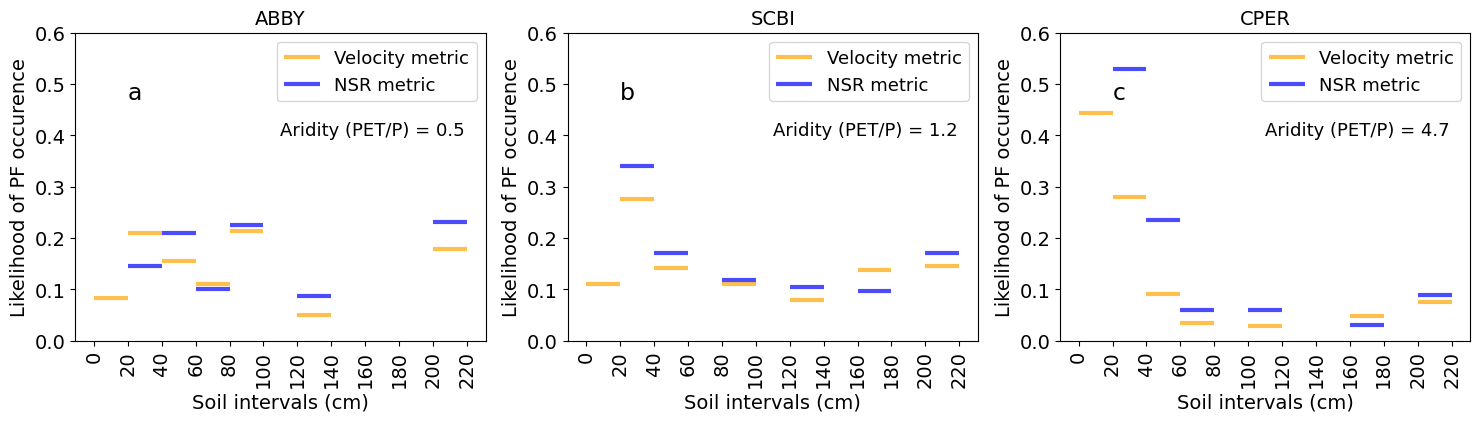

In [67]:
def get_step_plots():
    def get_percent(st, vars):
        nsr_depth = PF_info.loc[(PF_info["ft"] == vars) & (PF_info["site"] == st), :].groupby("mapped_flow_depth").agg({"ft": "count"})
        nsr_depth["percent"] =nsr_depth/nsr_depth.sum()
        
        return nsr_depth.reset_index().rename(columns = {"mapped_flow_depth":"map_depth"})

    fig, ax  = plt.subplots(1,3, figsize = (18,4))
    sites = ["ABBY", "SCBI", "CPER"]
    NUM= ["a", "b", "c"]
    for i in np.arange(len(sites)):
        PF_by_v = get_percent(sites[i],"V")
        PF_by_nsr = get_percent(sites[i],"PF")
        
        place_holder= pd.DataFrame(np.linspace(20,220,11), columns=["map_depth"])
        PF_by_v = pd.merge(PF_by_v, place_holder , how = "outer", on = "map_depth", sort=True)
        PF_by_v["lower"] = PF_by_v["map_depth"].shift()
        PF_by_nsr = pd.merge(PF_by_nsr, place_holder , how = "outer", on = "map_depth", sort=True)
        PF_by_nsr["lower"] = PF_by_nsr["map_depth"].shift()
        PF_by_v.loc[0, "lower"] = 0
        PF_by_nsr.loc[0, "lower"] = 0
        ax[i].hlines(PF_by_v["percent"], PF_by_v["lower"], 
                    PF_by_v["map_depth"], lw = 3,
                    colors = "orange", alpha = 0.7, label = "Velocity metric")
        ax[i].hlines(PF_by_nsr["percent"], PF_by_nsr["lower"], 
                    PF_by_nsr["map_depth"], lw = 3,
                    colors = "blue", alpha = 0.7, label ="NSR metric")

        ax[i].tick_params("both", labelsize = 14)
        ax[i].set_ylabel("Likelihood of PF occurence", fontsize= 14)
        ax[i].set_xlabel("Soil intervals (cm)", fontsize= 14)
        ax[i].set_xticks(np.arange(0,240,20))
        ax[i].set_yticks(np.linspace(0,0.6,7))
        ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 90)
        ax[i].set_title(sites[i], fontsize = 14)
        ax[i].text(110, 0.4, f"Aridity (PET/P) = {get_aridity(sites[i]):.1f}", fontsize= 13)
        ax[i].text(20, 0.47, NUM[i], fontsize = 17)

        ax[i].legend(fontsize =13)
get_step_plots()

In [68]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

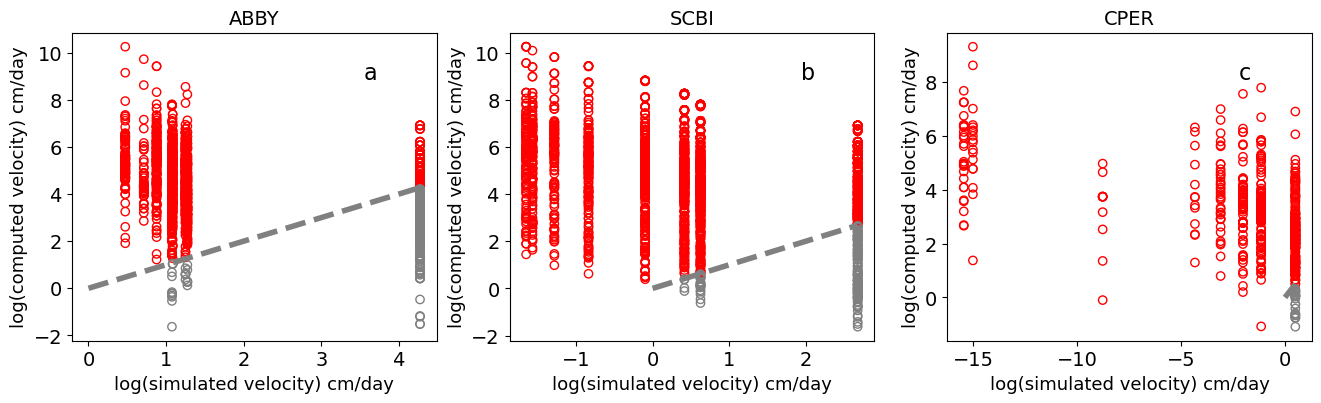

In [69]:
sites = ["ABBY", "SCBI", "CPER"]
sp = [f"50{j}" for j in np.arange(1,9)]
dt = all_neon_info[all_neon_info["ft"].isin(["no_PF_V", "V"])].copy()
num = ["a", "b", "c"]
fig, ax = plt.subplots(1,3, figsize = (16,4))
for i in np.arange(len(sites)):
    max_simu = 0
    min_simu = 0
    for j in sp:
        j_data = dt.loc[(dt["site"] == sites[i]), [f"velocity_computed_{j}", f"num_velocity_{j}_99th", "ft"]]
        # potential pf 
        potential_pf = j_data[(j_data[f"num_velocity_{j}_99th"] < j_data[f"velocity_computed_{j}"])]
        no_pf = j_data[(j_data[f"num_velocity_{j}_99th"] >= j_data[f"velocity_computed_{j}"])]
        ax[i].scatter(potential_pf[f"num_velocity_{j}_99th"], potential_pf[f"velocity_computed_{j}"], edgecolors = "red", facecolor = "none")
        ax[i].scatter(no_pf[f"num_velocity_{j}_99th"], no_pf[f"velocity_computed_{j}"], edgecolors = "grey", facecolor = "none")

        if j_data[f"num_velocity_{j}_99th"].max() > max_simu:
            max_simu = j_data[f"num_velocity_{j}_99th"].max()
        if j_data[f"num_velocity_{j}_99th"].min() > max_simu:
            min_simu = j_data[f"num_velocity_{j}_99th"].min()
    # ax[i].set_xlim(min_simu, max_simu)
    # ax[i].set_ylim(min_simu, max_simu)
    ax[i].plot([min_simu, max_simu], [min_simu, max_simu], c= "grey", lw = 4, ls = "dashed")
    ax[i].set_title(sites[i], fontsize = 14)
    ax[i].set_xlabel("log(simulated velocity) cm/day", fontsize =13)
    ax[i].set_ylabel("log(computed velocity) cm/day", fontsize =13)
    ax[i].text(0.8,0.85, num[i],fontsize = 16, transform = ax[i].transAxes)
    ax[i].tick_params("both", labelsize=14)

In [122]:
velocity_example = all_neon_info[(all_neon_info["ft"] == "V") & (all_neon_info["site"] == "ABBY")].iloc[0].dropna()

In [123]:
velocity_example

stormStartTime             2017-09-17 21:10:00
stormEndTime               2017-09-17 23:10:00
stormStartValue                          0.497
stormEndValue                            0.497
stormSum                                 5.467
stormPeakIntensity                       1.491
stormPeakTime              2017-09-17 22:50:00
stormDuration                         2.166667
smOnsetTime_501            2017-09-18 15:20:00
smPeakTime_501             2017-09-18 15:40:00
smOnset_501                            0.15075
smPeak_501                               0.162
sm7DaysMean_501                       0.053892
sm14DaysMean_501                      0.050989
precip7DaySum_501                        5.467
precip14DaySum_501                       7.455
precipOnsetToOnset_501                   5.467
smOnsetTime_502            2017-09-18 15:20:00
smPeakTime_502             2017-09-18 15:40:00
smOnset_502                            0.05165
smPeak_502                              0.0725
sm7DaysMean_5

In [191]:
storm_starts = pd.to_datetime(velocity_example["stormStartTime"])
storm_ends = pd.to_datetime(velocity_example["stormEndTime"])
storm_start_val = velocity_example["stormStartValue"]
storm_end_val = velocity_example["stormEndValue"]

sm_starts =  pd.to_datetime(velocity_example["smOnsetTime_502"])
sm_peak =  pd.to_datetime(velocity_example["smPeakTime_502"])
sm_onset_val = velocity_example["smOnset_502"]
sm_peak_val = velocity_example["smPeak_502"]

h_pos, v_pos = velocity_example["sensor_nake_name_502"].split("_")
log_v = velocity_example["velocity_computed_502"]
num_v = velocity_example["num_velocity_502_99th"]

pf_v_indicator= velocity_example["PF_velocity_metric_502"]

In [93]:
pf_v_indicator

True

In [192]:
example_sm = pd.read_csv(
    f"E:/AI4PF/SSSA_2023/soil_moisture/ABBY_sm_{h_pos}.csv",
)
example_precip = pd.read_csv(
    "E:/AI4PF/SSSA_2023/precipitation/ABBY_precip.csv",
)
example_precip["startDateTime"] = pd.to_datetime(example_precip["startDateTime"])
example_sm["startDateTime"] = pd.to_datetime(example_sm["startDateTime"])
example_precip.set_index("startDateTime", inplace=True)
example_sm.set_index("startDateTime", inplace=True)

In [193]:
precip_between = example_precip.loc[storm_starts:storm_ends, ]
sm_between = example_sm.loc[storm_starts: max(storm_ends, sm_peak) + pd.Timedelta(3, unit="H"), f"VSWCMean_{v_pos}"]

Text(0.5, 1.0, 'ABBY, sensor depth = 16 cm')

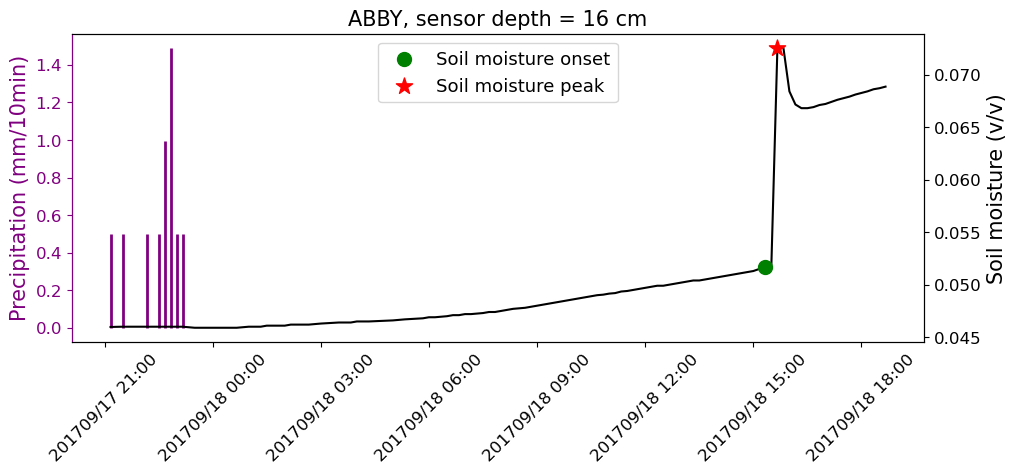

In [253]:
fig, ax = plt.subplots(figsize=(11,4))
ax.vlines(precip_between.index, 0, precip_between["precip"], color = "purple", lw= 2)
ax.tick_params("y", colors = "purple", labelsize = 12)
ax.set_ylabel("Precipitation (mm/10min)", fontsize = 15, color = "purple")
ax.tick_params(axis='x', labelrotation=45, labelsize = 12)

ax2 = ax.twinx()

ax2.plot(sm_between, c = "black")
ax2.tick_params("y", labelsize = 12)
ax2.set_ylabel("Soil moisture (v/v)", fontsize = 15)
ax2.spines["left"].set_color("purple")
import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%Y%m/%d %H:%M')
ax2.xaxis.set_major_formatter(date_format)
ax2.scatter(sm_starts, sm_onset_val, label = "Soil moisture onset",
            marker="o", c= "green", zorder =2, s = 100)
ax2.scatter(sm_peak, sm_peak_val, label = "Soil moisture peak", marker="*", c= "red",
            s = 150, zorder = 2)
ax2.legend(loc = "upper center", fontsize = 13)

ax.set_title(f"ABBY, sensor depth = {int(get_sensor_depth('ABBY', h_pos, v_pos, sm_starts))} cm", fontsize = 15)